# Data Pre-Processing: Part I
The purpose of this document is to split the forcing data and the velocity results for a single member. First, we load in the relevant libraries and packages.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *

%matplotlib inline

Next, go to http://www.pik-potsdam.de/~albrecht/pism_paleo_climate/ and download `timeseries_edc-wdc_temp.nc` and `velsurf_mag_100yr_d1.nc`. Put them in the directory you are working in. Since these data files can be quite large, they are not immediately included in this repository.

Once these files have been downloaded, we can open up and look at the data.

In [2]:
vels = xr.open_dataset('velsurf_mag_100yr_d1.nc',decode_times=False)

In [3]:
vels['time'] = vels.time/31536000

In [4]:
vels

<xarray.Dataset>
Dimensions:      (time: 1249, bnds: 2, x: 381, y: 381)
Coordinates:
  * time         (time) float64 -1.249e+05 -1.248e+05 -1.247e+05 ... 0.0 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (time, bnds) float64 ...
    velsurf_mag  (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...
    history:      Sun Nov 13 20:28:46 2022: ncatted -O -a history_of_appended...
    NCO:          netCDF Operators version 4.7.8 (Homepage = http://nco.sf.ne...

Select our time ranges for training and testing. We will split it so the first 104,900 years of the simulation are to train the models with, and the last 20,000 years will be used for prediction/testing.

In [5]:
time_range_train = np.arange(0,1049,1)
time_range_test = np.arange(-200,0,1)

In [6]:
vels_train = vels.isel(time=time_range_train)

In [7]:
vels_test = vels.isel(time=time_range_test)

Next we need to interpolate the time series such that it matches the time of the simulation results

In [8]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)

In [9]:
ds_forcing_train = ds_forcing.interp(time=vels_train.time)

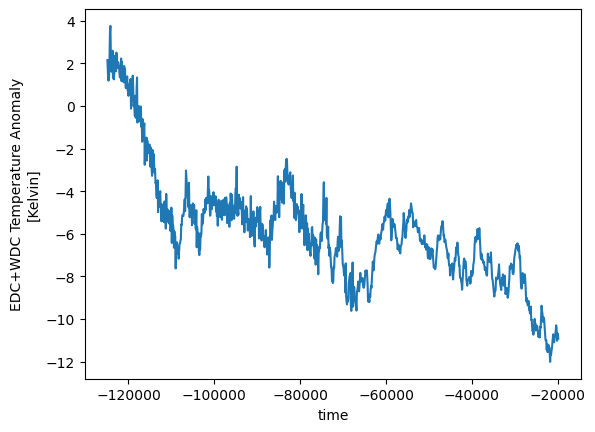

In [10]:
ds_forcing_train.delta_T.plot()

In [11]:
ds_forcing_test = ds_forcing.interp(time=vels_test.time)

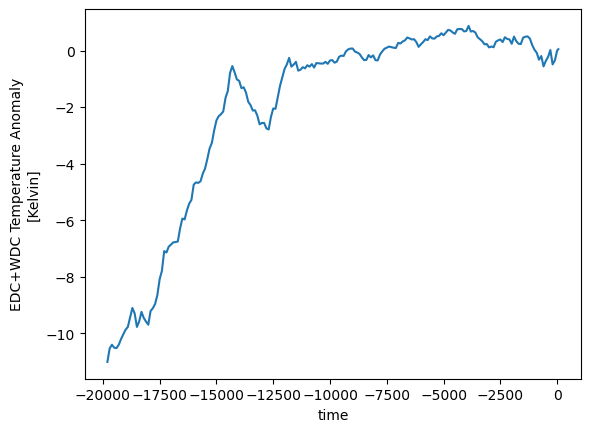

In [12]:
ds_forcing_test.delta_T.plot()

Finally, we preprocess the ocean temperature forcing, as although it generally follows temperature as shown in the exploratory data, it has more variance spatially and could probably influence the velocities near the ocean. 

In [13]:
oc_forcing = xr.open_dataset('schmidtko14_edc-wdc_oceantemp_basins_response_fit_16km-d1.nc',decode_times=False)

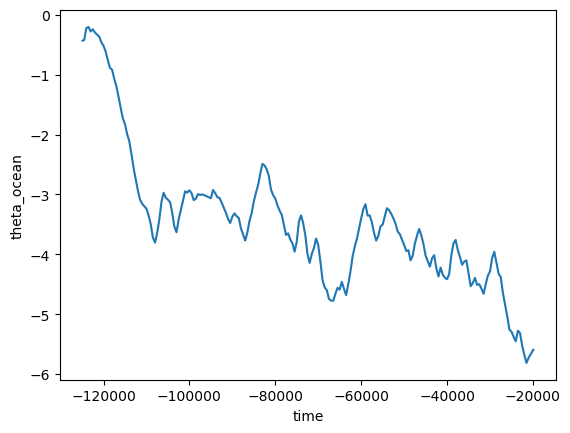

In [14]:
oc_forcing_train = oc_forcing.interp(time=vels_train.time)
oc_forcing_train.theta_ocean.mean(dim=['x','y']).plot()

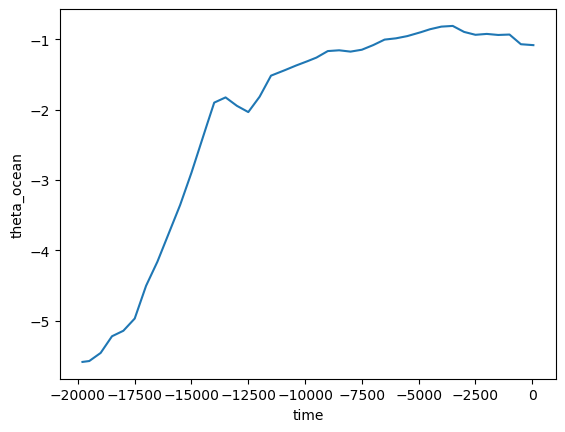

In [15]:
oc_forcing_test = oc_forcing.interp(time=vels_test.time)
oc_forcing_test.theta_ocean.mean(dim=['x','y']).plot()

Now we save the data

In [16]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

In [17]:
# Saving (do not run if already saved)
vels_train.to_netcdf( os.path.join(train_path,'member_165_train.nc'))
vels_test.to_netcdf( os.path.join(test_path,'member_165_test.nc'))
ds_forcing_train.to_netcdf( os.path.join(train_path,'forcing_train.nc'))
ds_forcing_test.to_netcdf( os.path.join(test_path,'forcing_test.nc'))
oc_forcing_train.to_netcdf( os.path.join(train_path,'oc_forcing_train.nc'))
oc_forcing_test.to_netcdf( os.path.join(test_path,'oc_forcing_test.nc'))